In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
#显示Dateframe所有列(参数设置为None代表显示所有行，也可以自行设置数字)
pd.set_option('display.max_columns',None)
#显示Dateframe所有行
pd.set_option('display.max_rows',None)
#设置Dataframe数据的显示长度，默认为50
pd.set_option('max_colwidth',200)
#不显示科学计数法，保留5位小数
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import numpy as np
import datetime
import os
from tqdm import tqdm
import talib
from talib import abstract
from finta import TA
import mplfinance as mpf
from alpha_factors.high_freq_factors import *
from joblib import *
from IPython.display import clear_output

In [2]:
path = 'C:\\Users\\budin\\Desktop\\强化学习\\螺纹钢\\5分钟 - 副本\\数据\\'
dir_list = os.listdir(path)
train_df = pd.DataFrame()
for i in range(len(dir_list)):
    if 'train' in dir_list[i]:
        tmp_df = pd.read_csv(path+dir_list[i])
        train_df = train_df.append(tmp_df)
    else:
        pass
train_df = train_df.drop(columns='Unnamed: 0').rename(columns={'symbol':'underlaying_symbols', 'datetime': 'date'})
train_df['tic'] = ['RB']*len(train_df)
train_df = train_df[['date', 'tic', 'underlaying_symbols', 'open', 'high', 'low', 'close', 'volume', 'open_oi', 'close_oi']]
tickers = ['RB']

train_df.shape, train_df.head(5), train_df.dtypes

((6558, 10),
                   date tic underlaying_symbols       open       high  \
 0  2022-08-24 21:00:00  RB         SHFE.rb2210 4082.00000 4089.00000   
 1  2022-08-24 21:05:00  RB         SHFE.rb2210 4089.00000 4100.00000   
 2  2022-08-24 21:10:00  RB         SHFE.rb2210 4086.00000 4095.00000   
 3  2022-08-24 21:15:00  RB         SHFE.rb2210 4085.00000 4090.00000   
 4  2022-08-24 21:20:00  RB         SHFE.rb2210 4084.00000 4091.00000   
 
          low      close      volume       open_oi      close_oi  
 0 4081.00000 4086.00000 45466.00000 1289350.00000 1288077.00000  
 1 4083.00000 4086.00000 65069.00000 1288077.00000 1286786.00000  
 2 4082.00000 4085.00000 23530.00000 1286786.00000 1285704.00000  
 3 4079.00000 4084.00000 18618.00000 1285704.00000 1284464.00000  
 4 4082.00000 4091.00000 16848.00000 1284464.00000 1283701.00000  ,
 date                    object
 tic                     object
 underlaying_symbols     object
 open                   float64
 high           

# Reduce Contract Change Gap

In [3]:
contracts = train_df['underlaying_symbols'].unique()
indexes = []
for i in range(len(contracts)):
    tmp_df = train_df[train_df['underlaying_symbols']==contracts[i]]
    tmp_index = tmp_df.index
    indexes.append([tmp_index])
    
indexes

[[Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
              ...
              210, 211, 212, 213, 214, 215, 216, 217, 218, 219],
             dtype='int64', length=220)],
 [Int64Index([ 220,  221,  222,  223,  224,  225,  226,  227,  228,  229,
              ...
              4127, 4128, 4129, 4130, 4131, 4132, 4133, 4134, 4135, 4136],
             dtype='int64', length=3917)],
 [Int64Index([4137, 4138, 4139, 4140, 4141, 4142, 4143, 4144, 4145, 4146,
              ...
              6548, 6549, 6550, 6551, 6552, 6553, 6554, 6555, 6556, 6557],
             dtype='int64', length=2421)]]

## Inspect Individual Price Gaps 

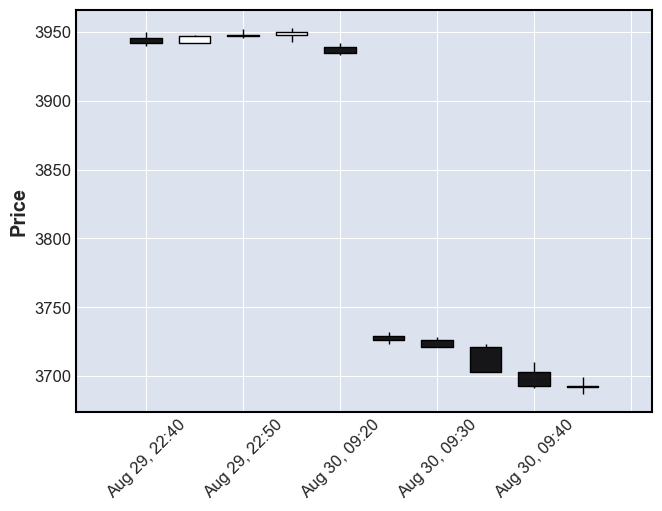

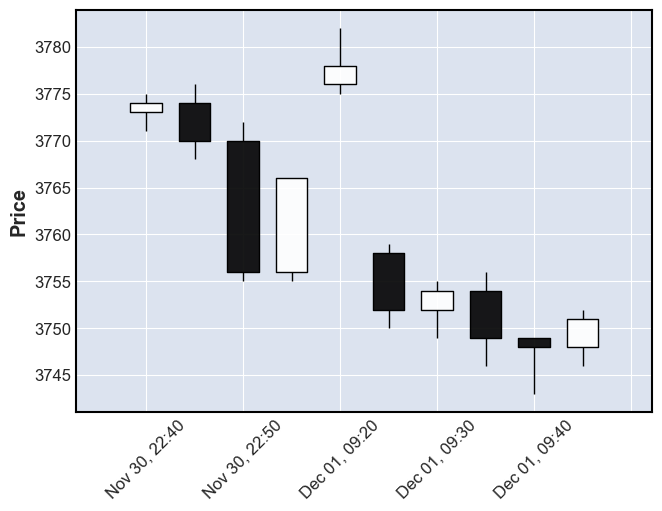

In [4]:
for i in range(1, len(contracts)):
    last_index_end = indexes[i-1][0][-5]
    this_index_start = indexes[i][0][5]
    tmp_df = train_df.iloc[last_index_end:this_index_start].set_index('date')
    tmp_df.index = pd.to_datetime(tmp_df.index)
    mpf.plot(tmp_df, type='candle')

## Adjust Individual Price Gaps

In [5]:
price_adjs = []
for i in range(1, len(contracts)):
    tmp_index = indexes[i][0]
    last_price = train_df['close'].iloc[indexes[i-1][0][-1]]
    now_price = train_df['close'].iloc[indexes[i][0][0]]
    price_adj = now_price - last_price
    print(price_adj)
    train_df['close'].iloc[tmp_index] = train_df['close'].iloc[tmp_index] - price_adj
    train_df['high'].iloc[tmp_index] = train_df['high'].iloc[tmp_index] - price_adj
    train_df['low'].iloc[tmp_index] = train_df['low'].iloc[tmp_index] - price_adj
    train_df['open'].iloc[tmp_index] = train_df['open'].iloc[tmp_index] - price_adj
    
train_df.head(5)

-209.0
-235.0


,date,tic,underlaying_symbols,open,high,low,close,volume,open_oi,close_oi
0,2022-08-24 21:00:00,RB,SHFE.rb2210,4082.00000,4089.00000,4081.00000,4086.00000,45466.00000,1289350.00000,1288077.00000
1,2022-08-24 21:05:00,RB,SHFE.rb2210,4089.00000,4100.00000,4083.00000,4086.00000,65069.00000,1288077.00000,1286786.00000
2,2022-08-24 21:10:00,RB,SHFE.rb2210,4086.00000,4095.00000,4082.00000,4085.00000,23530.00000,1286786.00000,1285704.00000
3,2022-08-24 21:15:00,RB,SHFE.rb2210,4085.00000,4090.00000,4079.00000,4084.00000,18618.00000,1285704.00000,1284464.00000
4,2022-08-24 21:20:00,RB,SHFE.rb2210,4084.00000,4091.00000,4082.00000,4091.00000,16848.00000,1284464.00000,1283701.00000


## Varify Individual Price Gaps 

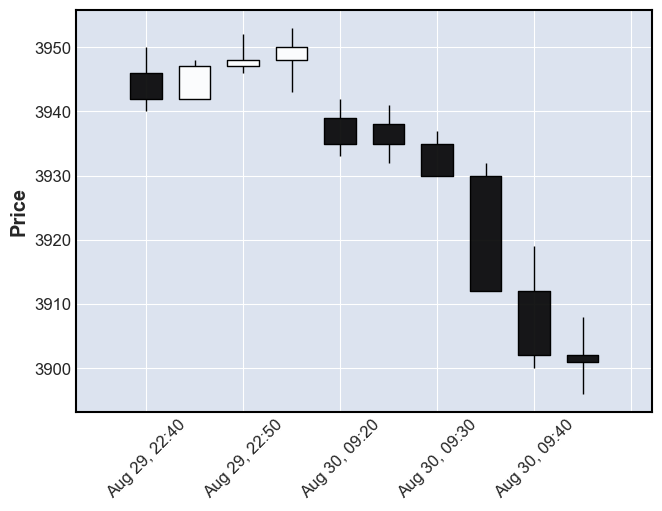

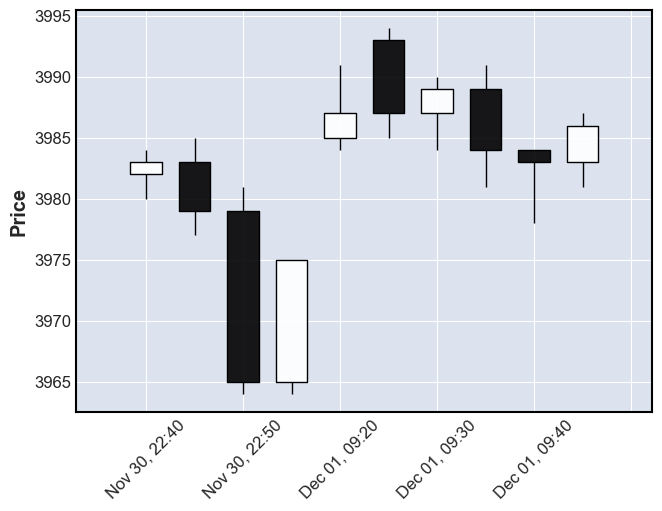

In [6]:
for i in range(1, len(contracts)):
    last_index_end = indexes[i-1][0][-5]
    this_index_start = indexes[i][0][5]
    tmp_df = train_df.iloc[last_index_end:this_index_start].set_index('date')
    tmp_df.index = pd.to_datetime(tmp_df.index)
    mpf.plot(tmp_df, type='candle')

# Get All Features

In [7]:
def jq_factors_futures(df, tic, high, low, open_, close, volume):
    #1 Volume Adjusted Moving Average
    df['VAMA3'] = TA.VAMA(df, 3).fillna(0)
    df['VAMA5'] = TA.VAMA(df, 5).fillna(0)
    df['VAMA8'] = TA.VAMA(df, 8).fillna(0)
    df['VAMA13'] = TA.VAMA(df, 13).fillna(0)
    df['VAMA34'] = TA.VAMA(df, 34).fillna(0)
    df['VAMA55'] = TA.VAMA(df, 55).fillna(0)
    df['VAMA88'] = TA.VAMA(df, 88).fillna(0)
    
    #2 The Kaufman Efficiency indicator is an oscillator indicator that oscillates between +100 and -100, where zero is the center point.
    #+100 is upward forex trending market and -100 is downwards trending markets.
    df['ER3'] = TA.ER(df, 3).fillna(0)
    df['ER5'] = TA.ER(df, 5).fillna(0)
    df['ER8'] = TA.ER(df, 8).fillna(0)
    df['ER13'] = TA.ER(df, 13).fillna(0)
    df['ER34'] = TA.ER(df, 34).fillna(0)
    df['ER55'] = TA.ER(df, 55).fillna(0)
    df['ER88'] = TA.ER(df, 88).fillna(0)    
    
    #3 ZLEMA is an abbreviation of Zero Lag Exponential Moving Average. It was developed by John Ehlers and Rick Way.
    #ZLEMA is a kind of Exponential moving average but its main idea is to eliminate the lag arising from the very nature 
    #of the moving averages and other trend following indicators. As it follows price closer, it also provides better price 
    #averaging and responds better to price swings.
    df['ZLEMA3'] = TA.ZLEMA(df, 3).fillna(0)
    df['ZLEMA5'] = TA.ZLEMA(df, 5).fillna(0)
    df['ZLEMA8'] = TA.ZLEMA(df, 8).fillna(0)
    df['ZLEMA13'] = TA.ZLEMA(df, 13).fillna(0)
    df['ZLEMA34'] = TA.ZLEMA(df, 34).fillna(0)
    df['ZLEMA55'] = TA.ZLEMA(df, 55).fillna(0)
    df['ZLEMA88'] = TA.ZLEMA(df, 88).fillna(0) 
    
    #4  HMA indicator is a common abbreviation of Hull Moving Average.
    #    The average was developed by Allan Hull and is used mainly to identify the current market trend.
    #    Unlike SMA (simple moving average) the curve of Hull moving average is considerably smoother.
    #    Moreover, because its aim is to minimize the lag between HMA and price it does follow the price activity much closer.
    #    It is used especially for middle-term and long-term trading.
    df['HMA3'] = TA.HMA(df, 3).fillna(0)
    df['HMA5'] = TA.HMA(df, 5).fillna(0)
    df['HMA8'] = TA.HMA(df, 8).fillna(0)
    df['HMA13'] = TA.HMA(df, 13).fillna(0)
    df['HMA34'] = TA.HMA(df, 34).fillna(0)
    df['HMA55'] = TA.HMA(df, 55).fillna(0)
    df['HMA88'] = TA.HMA(df, 88).fillna(0)  
    
    #5 The eVWMA can be looked at as an approximation to the
    #average price paid per share in the last n periods.
    df['EVWMA3'] = TA.EVWMA(df, 3).fillna(0)
    df['EVWMA5'] = TA.EVWMA(df, 5).fillna(0)
    df['EVWMA8'] = TA.EVWMA(df, 8).fillna(0)
    df['EVWMA13'] = TA.EVWMA(df, 13).fillna(0)
    df['EVWMA34'] = TA.EVWMA(df, 34).fillna(0)
    df['EVWMA55'] = TA.EVWMA(df, 55).fillna(0)
    df['EVWMA88'] = TA.EVWMA(df, 88).fillna(0)     
    
    #6 Fractal Adaptive Moving Average
    df['FRAMA2'] = TA.FRAMA(df, 2).fillna(0)
    df['FRAMA4'] = TA.FRAMA(df, 4).fillna(0)
    df['FRAMA8'] = TA.FRAMA(df, 8).fillna(0)
    df['FRAMA12'] = TA.FRAMA(df, 12).fillna(0)
    df['FRAMA34'] = TA.FRAMA(df, 34).fillna(0)
    df['FRAMA54'] = TA.FRAMA(df, 54).fillna(0)
    df['FRAMA88'] = TA.FRAMA(df, 88).fillna(0)
    
    #7 volume-Weighted MACD
    df['VW_MACD_1'], df['VW_MACD_2'] = TA.VW_MACD(df).fillna(0)
    
    #8 Elastic Volume Weighted MACD
    df['EV_MACD_1'], df['EV_MACD_2'] = TA.EV_MACD(df).fillna(0)
    
    #9 The Volatility-Based-Momentum (VBM) indicator
    df['VBM3'] = TA.VBM(df, 3).fillna(0)
    df['VBM5'] = TA.VBM(df, 5).fillna(0)
    df['VBM8'] = TA.VBM(df, 8).fillna(0)
    df['VBM13'] = TA.VBM(df, 13).fillna(0)
    df['VBM34'] = TA.VBM(df, 34).fillna(0)
    df['VBM55'] = TA.VBM(df, 55).fillna(0)
    df['VBM88'] = TA.VBM(df, 88).fillna(0)   
    
    #10 Modified Inverse Fisher Transform applied on RSI.
    df['IFT_RSI3'] = TA.IFT_RSI(df, 3).fillna(0)
    df['IFT_RSI5'] = TA.IFT_RSI(df, 5).fillna(0)
    df['IFT_RSI8'] = TA.IFT_RSI(df, 8).fillna(0)
    df['IFT_RSI13'] = TA.IFT_RSI(df, 13).fillna(0)
    df['IFT_RSI34'] = TA.IFT_RSI(df, 34).fillna(0)
    df['IFT_RSI55'] = TA.IFT_RSI(df, 55).fillna(0)
    df['IFT_RSI88'] = TA.IFT_RSI(df, 88).fillna(0) 
    
    #11 The Dynamic Momentum Index is a variable term RSI
    df['DYMI'] = TA.DYMI(df).fillna(0)
    
    #12 parabolic SAR indicator
    #df['PSAR_1'], df['PSAR_2'], df['PSAR_3'] = TA.PSAR(df).fillna(0)   
    
    #13 Keltner Channels [KC]
    tmp_df = pd.DataFrame()
    tmp_df = TA.KC(df).fillna(0)
    df = df.join(tmp_df)
    
    #14 Donchian Channel
    tmp_df = pd.DataFrame()
    tmp_df = TA.DO(df).fillna(0)
    df = df.join(tmp_df)
    
    #15 The directional movement indicator
    tmp_df = pd.DataFrame()
    tmp_df = TA.DMI(df, 3).fillna(0)
    df = df.join(tmp_df, lsuffix='_3', rsuffix='_3_1')
    tmp_df = pd.DataFrame()
    tmp_df = TA.DMI(df, 5).fillna(0)
    df = df.join(tmp_df, lsuffix='_5', rsuffix='_5_1')  
    tmp_df = pd.DataFrame()
    tmp_df = TA.DMI(df, 8).fillna(0)
    df = df.join(tmp_df, lsuffix='_8', rsuffix='_8_1') 
    tmp_df = pd.DataFrame()
    tmp_df = TA.DMI(df, 13).fillna(0)
    df = df.join(tmp_df, lsuffix='_13', rsuffix='_13_1') 
    tmp_df = pd.DataFrame()
    tmp_df = TA.DMI(df, 34).fillna(0)
    df = df.join(tmp_df, lsuffix='_34', rsuffix='_34_1') 
    tmp_df = pd.DataFrame()
    tmp_df = TA.DMI(df, 55).fillna(0)
    df = df.join(tmp_df, lsuffix='_55', rsuffix='_55_1') 
    tmp_df = pd.DataFrame()
    tmp_df = TA.DMI(df, 88).fillna(0)
    df = df.join(tmp_df, lsuffix='_88', rsuffix='_88_1') 
    
    #16 Pivot point
    #df['PIVOT'] = TA.PIVOT(df).fillna(0)  
    
    #16 Fibonacci pivot point
    #df['PIVOT_FIB'] = TA.PIVOT_FIB(df).fillna(0)
    
    #17 StochRSI
    df['STOCHRSI3'] = TA.STOCHRSI(df, 3).fillna(0)
    df['STOCHRSI5'] = TA.STOCHRSI(df, 5).fillna(0)
    df['STOCHRSI8'] = TA.STOCHRSI(df, 8).fillna(0)
    df['STOCHRSI13'] = TA.STOCHRSI(df, 13).fillna(0)
    df['STOCHRSI34'] = TA.STOCHRSI(df, 34).fillna(0)
    df['STOCHRSI55'] = TA.STOCHRSI(df, 55).fillna(0)
    df['STOCHRSI88'] = TA.STOCHRSI(df, 88).fillna(0)   
    
    #18 'EMA', Awesome Oscillator
    df['AO'] = TA.AO(df).fillna(0)
    
    #19 Mass Index
    df['MI3'] = TA.MI(df, 3).fillna(0)
    df['MI5'] = TA.MI(df, 5).fillna(0)
    df['MI8'] = TA.MI(df, 8).fillna(0)
    df['MI13'] = TA.MI(df, 13).fillna(0)
    df['MI34'] = TA.MI(df, 34).fillna(0)
    df['MI55'] = TA.MI(df, 55).fillna(0)
    df['MI88'] = TA.MI(df, 88).fillna(0)     
    
    #20 The Vortex indicator
    tmp_df = pd.DataFrame()
    tmp_df = TA.VORTEX(df, 3).fillna(0)
    df = df.join(tmp_df, lsuffix='_3', rsuffix='_3_1')    
    tmp_df = pd.DataFrame()
    tmp_df = TA.VORTEX(df, 5).fillna(0)
    df = df.join(tmp_df, lsuffix='_5', rsuffix='_5_1')
    tmp_df = pd.DataFrame()
    tmp_df = TA.VORTEX(df, 8).fillna(0)
    df = df.join(tmp_df, lsuffix='_8', rsuffix='_8_1')
    tmp_df = pd.DataFrame()
    tmp_df = TA.VORTEX(df, 13).fillna(0)
    df = df.join(tmp_df, lsuffix='_13', rsuffix='_13_1')
    tmp_df = pd.DataFrame()
    tmp_df = TA.VORTEX(df, 34).fillna(0)
    df = df.join(tmp_df, lsuffix='_34', rsuffix='_34_1')
    tmp_df = pd.DataFrame()
    tmp_df = TA.VORTEX(df, 55).fillna(0)
    df = df.join(tmp_df, lsuffix='_55', rsuffix='_55_1')
    tmp_df = pd.DataFrame()
    tmp_df = TA.VORTEX(df, 88).fillna(0)
    df = df.join(tmp_df, lsuffix='_88', rsuffix='_88_1')
    
    #21 Know Sure Thing (KST) is a momentum oscillator based on the smoothed rate-of-change for four different time frames.  
    tmp_df = pd.DataFrame()
    tmp_df = TA.KST(df).fillna(0) 
    df = df.join(tmp_df)
    
    #22 True Strength Index (TSI)
    tmp_df = pd.DataFrame()
    tmp_df = TA.TSI(df, 3).fillna(0) 
    df = df.join(tmp_df, lsuffix='_3', rsuffix='_3_1')
    tmp_df = pd.DataFrame()
    tmp_df = TA.TSI(df, 5).fillna(0) 
    df = df.join(tmp_df, lsuffix='_5', rsuffix='_5_1')
    tmp_df = pd.DataFrame()
    tmp_df = TA.TSI(df, 8).fillna(0) 
    df = df.join(tmp_df, lsuffix='_8', rsuffix='_8_1')
    tmp_df = pd.DataFrame()
    tmp_df = TA.TSI(df, 13).fillna(0) 
    df = df.join(tmp_df, lsuffix='_13', rsuffix='_13_1')
    tmp_df = pd.DataFrame()
    tmp_df = TA.TSI(df, 34).fillna(0) 
    df = df.join(tmp_df, lsuffix='_34', rsuffix='_34_1')
    tmp_df = pd.DataFrame()
    tmp_df = TA.TSI(df, 55).fillna(0) 
    df = df.join(tmp_df, lsuffix='_55', rsuffix='_55_1')
    tmp_df = pd.DataFrame()
    tmp_df = TA.TSI(df, 88).fillna(0) 
    df = df.join(tmp_df, lsuffix='_88', rsuffix='_88_1')
    
    #23 The accumulation/distribution line
    df['ADL'] = TA.ADL(df).fillna(0)
    
    #24 Weighted OBV
    df['WOBV'] = TA.WOBV(df).fillna(0)

    #25 VZO uses price, previous price and moving averages to compute its oscillating value
    df['VZO3'] = TA.VZO(df, 3).fillna(0)
    df['VZO5'] = TA.VZO(df, 5).fillna(0)
    df['VZO8'] = TA.VZO(df, 8).fillna(0)
    df['VZO13'] = TA.VZO(df, 13).fillna(0)
    df['VZO34'] = TA.VZO(df, 34).fillna(0)
    df['VZO55'] = TA.VZO(df, 55).fillna(0)
    df['VZO88'] = TA.VZO(df, 88).fillna(0)  
    
    #26 The formula for PZO depends on only one condition: if today's closing price is higher than yesterday's closing price,
    #then the closing price will have a positive value (bullish); otherwise it will have a negative value (bearish).
    df['PZO3'] = TA.PZO(df, 3).fillna(0)
    df['PZO5'] = TA.PZO(df, 5).fillna(0)
    df['PZO8'] = TA.PZO(df, 8).fillna(0)
    df['PZO13'] = TA.PZO(df, 13).fillna(0)
    df['PZO34'] = TA.PZO(df, 34).fillna(0)
    df['PZO55'] = TA.PZO(df, 55).fillna(0)
    df['PZO88'] = TA.PZO(df, 88).fillna(0)  
    
    #27 Elder's Force Index is an indicator that uses price and volume to assess the power
    #behind a move or identify possible turning points.
    df['EFI3'] = TA.EFI(df, 3).fillna(0)
    df['EFI5'] = TA.EFI(df, 5).fillna(0)
    df['EFI8'] = TA.EFI(df, 8).fillna(0)
    df['EFI13'] = TA.EFI(df, 13).fillna(0)
    df['EFI34'] = TA.EFI(df, 34).fillna(0)
    df['EFI55'] = TA.EFI(df, 55).fillna(0)
    df['EFI88'] = TA.EFI(df, 88).fillna(0) 
    
    #28 Cummulative Force Index.
    df['CFI'] = TA.CFI(df).fillna(0)
    
    #29 Bull power and bear power
    tmp_df = pd.DataFrame()
    tmp_df = TA.EBBP(df).fillna(0)
    df = df.join(tmp_df)
    
    #30 Coppock Curve
    df['COPP'] = TA.COPP(df).fillna(0)

    #31 BASP indicator serves to identify buying and selling pressure.
    tmp_df = pd.DataFrame()
    tmp_df = TA.BASP(df, 3).fillna(0)
    df = df.join(tmp_df, lsuffix='_3', rsuffix='_3_1')
    tmp_df = pd.DataFrame()
    tmp_df = TA.BASP(df, 5).fillna(0)
    df = df.join(tmp_df, lsuffix='_5', rsuffix='_5_1')
    tmp_df = pd.DataFrame()
    tmp_df = TA.BASP(df, 8).fillna(0)
    df = df.join(tmp_df, lsuffix='_8', rsuffix='_8_1')
    tmp_df = pd.DataFrame()
    tmp_df = TA.BASP(df, 13).fillna(0)
    df = df.join(tmp_df, lsuffix='_13', rsuffix='_13_1')
    tmp_df = pd.DataFrame()
    tmp_df = TA.BASP(df, 34).fillna(0)
    df = df.join(tmp_df, lsuffix='_34', rsuffix='_34_1')
    tmp_df = pd.DataFrame()
    tmp_df = TA.BASP(df, 55).fillna(0)
    df = df.join(tmp_df, lsuffix='_55', rsuffix='_55_1')
    tmp_df = pd.DataFrame()
    tmp_df = TA.BASP(df, 88).fillna(0)
    df = df.join(tmp_df, lsuffix='_88', rsuffix='_88_1')
    
    #32 Normalized BASP indicator
    tmp_df = pd.DataFrame()
    tmp_df = TA.BASPN(df, 3).fillna(0)
    df = df.join(tmp_df, lsuffix='_3', rsuffix='_3_1')    
    tmp_df = pd.DataFrame()
    tmp_df = TA.BASPN(df, 5).fillna(0)
    df = df.join(tmp_df, lsuffix='_5', rsuffix='_5_1') 
    tmp_df = pd.DataFrame()
    tmp_df = TA.BASPN(df, 8).fillna(0)
    df = df.join(tmp_df, lsuffix='_8', rsuffix='_8_1') 
    tmp_df = pd.DataFrame()
    tmp_df = TA.BASPN(df, 13).fillna(0)
    df = df.join(tmp_df, lsuffix='_13', rsuffix='_13_1') 
    tmp_df = pd.DataFrame()
    tmp_df = TA.BASPN(df, 34).fillna(0)
    df = df.join(tmp_df, lsuffix='_34', rsuffix='_34_1') 
    tmp_df = pd.DataFrame()
    tmp_df = TA.BASPN(df, 55).fillna(0)
    df = df.join(tmp_df, lsuffix='_55', rsuffix='_55_1') 
    tmp_df = pd.DataFrame()
    tmp_df = TA.BASPN(df, 88).fillna(0)
    df = df.join(tmp_df, lsuffix='_88', rsuffix='_88_1')
    
    #33 Coppock Curve
    tmp_df = pd.DataFrame()
    tmp_df = TA.CHANDELIER(df).fillna(0)
    df = df.join(tmp_df)    
    
    #34 Wave Trend Oscillator
    tmp_df = pd.DataFrame()
    tmp_df = TA.WTO(df, 3).fillna(0)  
    df = df.join(tmp_df, lsuffix='_3', rsuffix='_3_1')   
    tmp_df = pd.DataFrame()
    tmp_df = TA.WTO(df, 5).fillna(0)  
    df = df.join(tmp_df, lsuffix='_5', rsuffix='_5_1')    
    tmp_df = pd.DataFrame()
    tmp_df = TA.WTO(df, 8).fillna(0)  
    df = df.join(tmp_df, lsuffix='_8', rsuffix='_8_1')    
    tmp_df = pd.DataFrame()
    tmp_df = TA.WTO(df, 13).fillna(0)  
    df = df.join(tmp_df, lsuffix='_13', rsuffix='_13_1')    
    tmp_df = pd.DataFrame()
    tmp_df = TA.WTO(df, 34).fillna(0)  
    df = df.join(tmp_df, lsuffix='_34', rsuffix='_34_1')    
    tmp_df = pd.DataFrame()
    tmp_df = TA.WTO(df, 55).fillna(0)  
    df = df.join(tmp_df, lsuffix='_55', rsuffix='_55_1')   
    tmp_df = pd.DataFrame()
    tmp_df = TA.WTO(df, 88).fillna(0)  
    df = df.join(tmp_df, lsuffix='_88', rsuffix='_88_1') 
    
    #35 Fisher Transform
    df['FISH3'] = TA.FISH(df, 3).fillna(0)
    df['FISH5'] = TA.FISH(df, 5).fillna(0)
    df['FISH8'] = TA.FISH(df, 8).fillna(0)
    df['FISH13'] = TA.FISH(df, 13).fillna(0)
    df['FISH34'] = TA.FISH(df, 34).fillna(0)
    df['FISH55'] = TA.FISH(df, 55).fillna(0)
    df['FISH88'] = TA.FISH(df, 88).fillna(0)   
    
    #36 The Ichimoku Cloud  
    tmp_df = pd.DataFrame()
    tmp_df = TA.ICHIMOKU(df).fillna(0)
    df = df.join(tmp_df) 
    
    '''
    #37 The adaptive price zone (APZ)
    tmp_df = pd.DataFrame()
    tmp_df = TA.APZ(df, 3).fillna(0)  
    df = df.join(tmp_df, lsuffix='_3', rsuffix='_3')    
    tmp_df = pd.DataFrame()
    tmp_df = TA.APZ(df, 5).fillna(0)  
    df = df.join(tmp_df, lsuffix='_5', rsuffix='_5')  
    tmp_df = pd.DataFrame()
    tmp_df = TA.APZ(df, 8).fillna(0)  
    df = df.join(tmp_df, lsuffix='_8', rsuffix='_8')  
    tmp_df = pd.DataFrame()
    tmp_df = TA.APZ(df, 13).fillna(0)  
    df = df.join(tmp_df, lsuffix='_13', rsuffix='_13')  
    tmp_df = pd.DataFrame()
    tmp_df = TA.APZ(df, 34).fillna(0)  
    df = df.join(tmp_df, lsuffix='_34', rsuffix='_34')  
    tmp_df = pd.DataFrame()
    tmp_df = TA.APZ(df, 55).fillna(0)  
    df = df.join(tmp_df, lsuffix='_55', rsuffix='_55')  
    tmp_df = pd.DataFrame()
    tmp_df = TA.APZ(df, 88).fillna(0)  
    df = df.join(tmp_df, lsuffix='_88', rsuffix='_88')  
    
    #38 Squeeze Momentum Indicator
    df['SQZMI3'] = TA.SQZMI(df, 3).fillna(0)
    df['SQZMI5'] = TA.SQZMI(df, 5).fillna(0)
    df['SQZMI8'] = TA.SQZMI(df, 8).fillna(0)
    df['SQZMI13'] = TA.SQZMI(df, 13).fillna(0)
    df['SQZMI34'] = TA.SQZMI(df, 34).fillna(0)
    df['SQZMI55'] = TA.SQZMI(df, 55).fillna(0)
    df['SQZMI88'] = TA.SQZMI(df, 88).fillna(0) 
    '''
    #39 Volume Price Trend
    df['VPT'] = TA.VPT(df).fillna(0)  
    
    #40 FVE is a money flow indicator
    df['FVE'] = TA.FVE(df).fillna(0)  
    
    #41 This indicator tracks volume based on the direction of price movement.
    df['VFI'] = TA.VFI(df).fillna(0)  
    
    #42 Volume Price Trend
    df['STC3'] = TA.STC(df, 3).fillna(0)
    df['STC5'] = TA.STC(df, 5).fillna(0)
    df['STC8'] = TA.STC(df, 8).fillna(0)
    df['STC13'] = TA.STC(df, 13).fillna(0)
    df['STC34'] = TA.STC(df, 34).fillna(0)
    df['STC55'] = TA.STC(df, 55).fillna(0)
    df['STC88'] = TA.STC(df, 88).fillna(0)    
    
    #43 Modification of Schaff Trend Cycle using EVWMA MACD for calculation
    df['EVSTC'] = TA.EVSTC(df).fillna(0)
    
    #44 Williams Fractal Indicato, all zeros
    '''
    tmp_df = pd.DataFrame()
    tmp_df = TA.WILLIAMS_FRACTAL(df, 3).fillna(0)
    df = df.join(tmp_df, lsuffix='_3', rsuffix='_3_1')  
    tmp_df = pd.DataFrame()
    tmp_df = TA.WILLIAMS_FRACTAL(df, 5).fillna(0)
    df = df.join(tmp_df, lsuffix='_5', rsuffix='_5_1') 
    tmp_df = pd.DataFrame()
    tmp_df = TA.WILLIAMS_FRACTAL(df, 8).fillna(0)
    df = df.join(tmp_df, lsuffix='_8', rsuffix='_8_1') 
    tmp_df = pd.DataFrame()
    tmp_df = TA.WILLIAMS_FRACTAL(df, 13).fillna(0)
    df = df.join(tmp_df, lsuffix='_13', rsuffix='_13_1') 
    tmp_df = pd.DataFrame()
    tmp_df = TA.WILLIAMS_FRACTAL(df, 34).fillna(0)
    df = df.join(tmp_df, lsuffix='_34', rsuffix='_34_1') 
    tmp_df = pd.DataFrame()
    tmp_df = TA.WILLIAMS_FRACTAL(df, 55).fillna(0)
    df = df.join(tmp_df, lsuffix='_55', rsuffix='_55_1') 
    tmp_df = pd.DataFrame()
    tmp_df = TA.WILLIAMS_FRACTAL(df, 88).fillna(0)
    df = df.join(tmp_df, lsuffix='_88', rsuffix='_88_1') 
    '''
    #6意愿指标
    df['BR6'] = ((df.high-df.close.shift(1)).rolling(6).sum())/\
                    ((df.close.shift(1)-df.low).rolling(6).sum())*100    
    df['BR13'] = ((df.high-df.close.shift(1)).rolling(13).sum())/\
                    ((df.close.shift(1)-df.low).rolling(13).sum())*100
    df['BR26'] = ((df.high-df.close.shift(1)).rolling(26).sum())/\
                    ((df.close.shift(1)-df.low).rolling(26).sum())*100
    df['BR34'] = ((df.high-df.close.shift(1)).rolling(34).sum())/\
                    ((df.close.shift(1)-df.low).rolling(34).sum())*100
    df['BR55'] = ((df.high-df.close.shift(1)).rolling(55).sum())/\
                    ((df.close.shift(1)-df.low).rolling(55).sum())*100
    df['BR88'] = ((df.high-df.close.shift(1)).rolling(88).sum())/\
                    ((df.close.shift(1)-df.low).rolling(88).sum())*100
    df['BR120'] = ((df.high-df.close.shift(1)).rolling(120).sum())/\
                    ((df.close.shift(1)-df.low).rolling(120).sum())*100
    
    #7VMACD因子的中间变量
    df['CDIFF'] = talib.EMA(df.close, 12)-talib.EMA(df.close, 26)
    df['VDIFF'] = talib.EMA(df.volume, 12)-talib.EMA(df.volume, 26)
    #df['PDIFF'] = talib.EMA(df.pos_chg, 12)-talib.EMA(df.pos_chg, 26)
    
    #11VDEA, VMACD因子的中间变量
    df['CDEA'] = talib.EMA(df.CDIFF.fillna(0), 9)
    df['CDEA13'] = talib.EMA(df.CDIFF.fillna(0), 13)
    df['CDEA34'] = talib.EMA(df.CDIFF.fillna(0), 34)
    df['CDEA55'] = talib.EMA(df.CDIFF.fillna(0), 55)
    df['CDEA88'] = talib.EMA(df.CDIFF.fillna(0), 88)
    df['CDEA120'] = talib.EMA(df.CDIFF.fillna(0), 120)
    df['VDEA'] = talib.EMA(df.VDIFF.fillna(0), 9)
    df['VDEA13'] = talib.EMA(df.VDIFF.fillna(0), 13)
    df['VDEA34'] = talib.EMA(df.VDIFF.fillna(0), 34)
    df['VDEA55'] = talib.EMA(df.VDIFF.fillna(0), 55)
    df['VDEA88'] = talib.EMA(df.VDIFF.fillna(0), 88)
    df['VDEA120'] = talib.EMA(df.VDIFF.fillna(0), 120)
    '''
    df['PDEA'] = talib.EMA(df.PDIFF.fillna(0), 9)
    df['PDEA13'] = talib.EMA(df.PDIFF.fillna(0), 13)
    df['PDEA34'] = talib.EMA(df.PDIFF.fillna(0), 34)
    df['PDEA55'] = talib.EMA(df.PDIFF.fillna(0), 55)
    df['PDEA88'] = talib.EMA(df.PDIFF.fillna(0), 88)
    df['PDEA120'] = talib.EMA(df.PDIFF.fillna(0), 120) 
    '''   
    
    #8威廉变异离散量
    df['WVAD6'] = ((df.close-df.open)/(df.high-df.low)*df.volume).rolling(6).sum()
    df['WVAD13'] = ((df.close-df.open)/(df.high-df.low)*df.volume).rolling(13).sum()
    df['WVAD34'] = ((df.close-df.open)/(df.high-df.low)*df.volume).rolling(34).sum()
    df['WVAD55'] = ((df.close-df.open)/(df.high-df.low)*df.volume).rolling(55).sum()
    df['WVAD88'] = ((df.close-df.open)/(df.high-df.low)*df.volume).rolling(88).sum()
    df['WVAD120'] = ((df.close-df.open)/(df.high-df.low)*df.volume).rolling(120).sum()
    
    #13人气指标
    df['AR6'] = ((df.high-df.open).rolling(6).sum())/((df.open-df.low).rolling(6).sum())*100
    df['AR13'] = ((df.high-df.open).rolling(13).sum())/((df.open-df.low).rolling(13).sum())*100
    df['AR26'] = ((df.high-df.open).rolling(26).sum())/((df.open-df.low).rolling(26).sum())*100
    df['AR34'] = ((df.high-df.open).rolling(34).sum())/((df.open-df.low).rolling(34).sum())*100
    df['AR55'] = ((df.high-df.open).rolling(55).sum())/((df.open-df.low).rolling(55).sum())*100
    df['AR88'] = ((df.high-df.open).rolling(88).sum())/((df.open-df.low).rolling(88).sum())*100
    df['AR120'] = ((df.high-df.open).rolling(120).sum())/((df.open-df.low).rolling(120).sum())*100
    
    #16因子 AR 与因子 BR 的差
    df['ARBR6'] = df.AR6-df.BR6
    df['ARBR13'] = df.AR13-df.BR13
    df['ARBR26'] = df.AR26-df.BR26
    df['ARBR34'] = df.AR34-df.BR34
    df['ARBR55'] = df.AR55-df.BR55
    df['ARBR88'] = df.AR88-df.BR88
    df['ARBR120'] = df.AR120-df.BR120
        
    #18收益方差
    df['rvar20'] = ((df.close-df.close.shift(20))/df.close.shift(20)).rolling(20).var().fillna(0)
    df['rvar60'] = ((df.close-df.close.shift(60))/df.close.shift(60)).rolling(60).var().fillna(0)
    df['rvar120'] = ((df.close-df.close.shift(120))/df.close.shift(120)).rolling(120).var().fillna(0)
    
    #18收益偏度
    df['rskew20'] = ((df.close-df.close.shift(20))/df.close.shift(20)).rolling(5).skew().fillna(0)
    df['rskew60'] = ((df.close-df.close.shift(60))/df.close.shift(60)).rolling(13).skew().fillna(0)
    df['rskew120'] = ((df.close-df.close.shift(120))/df.close.shift(120)).rolling(34).skew().fillna(0)
    
    #19收益峰度
    df['rkurtosis20'] = ((df.close-df.close.shift(20))/df.close.shift(20)).rolling(20).kurt().fillna(0)
    df['rkurtosis60'] = ((df.close-df.close.shift(60))/df.close.shift(60)).rolling(60).kurt().fillna(0)
    df['rkurtosis120'] = ((df.close-df.close.shift(120))/df.close.shift(120)).rolling(120).kurt().fillna(0)
    
    #20收益夏普比率
    df['sharpe20'] = (((df.close-df.close.shift(20))/df.close.shift(20))-0.028)/((df.close-df.close.shift(5))\
                        /df.close.shift(20)).rolling(13).std()
    df['sharpe60'] = (((df.close-df.close.shift(60))/df.close.shift(60))-0.028)/((df.close-df.close.shift(60))\
                        /df.close.shift(34)).rolling(60).std()
    df['sharpe120'] = (((df.close-df.close.shift(120))/df.close.shift(120))-0.028)/((df.close-df.close.shift(120))\
                        /df.close.shift(120)).rolling(55).std()
        
    #22空头力道
    df['bear_power5'] = (df.low.values-talib.EMA(close,5))/df.close.values
    df['bear_power13'] = (df.low.values-talib.EMA(close,13))/df.close.values
    df['bear_power34'] = (df.low.values-talib.EMA(close,34))/df.close.values
    df['bear_power55'] = (df.low.values-talib.EMA(close,55))/df.close.values
    df['bear_power88'] = (df.low.values-talib.EMA(close,88))/df.close.values
    df['bear_power120'] = (df.low.values-talib.EMA(close,120))/df.close.values
    
    #23乖离率
    df['bias1'] = (df.close-df.close.rolling(1).mean())/df.close.rolling(1).mean()*100
    df['bias3'] = (df.close-df.close.rolling(3).mean())/df.close.rolling(3).mean()*100
    df['bias5'] = (df.close-df.close.rolling(5).mean())/df.close.rolling(5).mean()*100
    df['bias10'] = (df.close-df.close.rolling(10).mean())/df.close.rolling(10).mean()*100
    df['bias20'] = (df.close-df.close.rolling(20).mean())/df.close.rolling(20).mean()*100
    df['bias60'] = (df.close-df.close.rolling(60).mean())/df.close.rolling(60).mean()*100
    df['bias120'] = (df.close-df.close.rolling(120).mean())/df.close.rolling(120).mean()*100
    
    #24多头力道
    df['bull_power5'] = df.high.values-talib.EMA(close,5)/df.close.values
    df['bull_power13'] = df.high.values-talib.EMA(close,13)/df.close.values
    df['bull_power34'] = df.high.values-talib.EMA(close,34)/df.close.values
    df['bull_power55'] = df.high.values-talib.EMA(close,55)/df.close.values
    df['bull_power88'] = df.high.values-talib.EMA(close,88)/df.close.values
    df['bull_power120'] = df.high.values-talib.EMA(close,120)/df.close.values
        
    #29单日价量趋势
    df['single_day_VPT'] = (df.close-df.close.shift(1))/df.close.shift(1)*df.volume
    df['single_day_VPT6'] = df.single_day_VPT.rolling(6).mean()
    df['single_day_VPT12'] = df.single_day_VPT.rolling(12).mean()
    df['single_day_VPT34'] = df.single_day_VPT.rolling(34).mean()
    df['single_day_VPT55'] = df.single_day_VPT.rolling(55).mean()
    df['single_day_VPT88'] = df.single_day_VPT.rolling(88).mean()
    df['single_day_VPT120'] = df.single_day_VPT.rolling(120).mean()
    
    #30均线交叉因子
    df['dema_1'] = talib.DEMA(close,13)/talib.DEMA(close,5)
    df['dema_2'] = talib.DEMA(close,34)/talib.DEMA(close,5)
    df['dema_3'] = talib.DEMA(close,55)/talib.DEMA(close,5)
    df['dema_4'] = talib.DEMA(close,88)/talib.DEMA(close,5)
    df['dema_5'] = talib.DEMA(close,120)/talib.DEMA(close,5)    
    
    df['ema_1'] = talib.EMA(close,13)/talib.EMA(close,5)
    df['ema_2'] = talib.EMA(close,34)/talib.EMA(close,5)
    df['ema_3'] = talib.EMA(close,55)/talib.EMA(close,5)
    df['ema_4'] = talib.EMA(close,88)/talib.EMA(close,5)
    df['ema_5'] = talib.EMA(close,120)/talib.EMA(close,5)
    
    df['kma_1'] = talib.KAMA(close,13)/talib.KAMA(close,5)
    df['kma_2'] = talib.KAMA(close,34)/talib.KAMA(close,5)
    df['kma_3'] = talib.KAMA(close,55)/talib.KAMA(close,5)
    df['kma_4'] = talib.KAMA(close,88)/talib.KAMA(close,5)
    df['kma_5'] = talib.KAMA(close,120)/talib.KAMA(close,5)
    
    '''
    #Alpha191
    df = GET_alpha(df)
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(0)
    
    #Alpha101
    df = get_alpha(df)
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(0)
    '''
    return df

def jq_factors_features_1(df, tic, high, low, open_, close, volume, amount):
    #1量变动速率指标
    # 12日量变动速率指标（Volume Rate of Change），以今天的成交量和N天前的成交量比较，
    # 通过计算某一段时间内成交量变动的幅度，应用成交量的移动比较来测量成交量运动趋向，
    # 达到事先探测成交量供需的强弱，进而分析成交量的发展趋势及其将来是否有转势的意愿，
    # 属于成交量的反趋向指标。属于成交量型因子
    df['VROC6'] = talib.ROC(volume, timeperiod=6)
    df['VROC12'] = talib.ROC(volume, timeperiod=12)
    df['VROC34'] = talib.ROC(volume, timeperiod=34)
    df['VROC55'] = talib.ROC(volume, timeperiod=55)
    df['VROC88'] = talib.ROC(volume, timeperiod=88)
    df['VROC120'] = talib.ROC(volume, timeperiod=120)
    
    #2成交金额的移动平均值
    df['TVMA6'] = talib.SMA(amount, timeperiod=6)
    df['TVMA20'] = talib.SMA(amount, timeperiod=20)
    df['TVMA34'] = talib.SMA(amount, timeperiod=34)
    df['TVMA55'] = talib.SMA(amount, timeperiod=55)
    df['TVMA88'] = talib.SMA(amount, timeperiod=88)
    df['TVMA120'] = talib.SMA(amount, timeperiod=120)
    
    #3成交量的指数移动平均
    df['VEMA5'] = talib.EMA(volume, timeperiod=5)
    df['VEMA10'] = talib.EMA(volume, timeperiod=10)
    df['VEMA26'] = talib.EMA(volume, timeperiod=26)
    df['VEMA34'] = talib.EMA(volume, timeperiod=34)
    df['VEMA55'] = talib.EMA(volume, timeperiod=55)
    df['VEMA88'] = talib.EMA(volume, timeperiod=88)
    df['VEMA120'] = talib.EMA(volume, timeperiod=120)
    
    #9成交量标准差
    df['VSTD10'] = talib.STDDEV(volume, timeperiod=10, nbdev=1)
    df['VSTD20'] = talib.STDDEV(volume, timeperiod=20, nbdev=1)
    df['VSTD34'] = talib.STDDEV(volume, timeperiod=34, nbdev=1)
    df['VSTD55'] = talib.STDDEV(volume, timeperiod=55, nbdev=1)
    df['VSTD88'] = talib.STDDEV(volume, timeperiod=88, nbdev=1)
    df['VSTD120'] = talib.STDDEV(volume, timeperiod=120, nbdev=1)
    
    #10均幅指标
    # 均幅指标（Average TRUE Ranger），取一定时间周期内的股价波动幅度的移动平均值，
    # 是显示市场变化率的指标，主要用于研判买卖时机。属于超买超卖型因子。
    df['ATR6'] = talib.ATR(high, low, close, timeperiod=6)
    df['ATR13'] = talib.ATR(high, low, close, timeperiod=13)
    df['ATR26'] = talib.ATR(high, low, close, timeperiod=26)
    df['ATR34'] = talib.ATR(high, low, close, timeperiod=34)
    df['ATR55'] = talib.ATR(high, low, close, timeperiod=55)
    df['ATR88'] = talib.ATR(high, low, close, timeperiod=88)
    df['ATR120'] = talib.ATR(high, low, close, timeperiod=120)
        
    #12成交量指数平滑异同移动平均线
    df['Vmacd'], df['Vmacds'], df['Vmacdh'] = talib.MACD(volume, fastperiod=12, slowperiod=26, signalperiod=9)
    #df['Amacd'], df['Amacds'], df['Amacdh'] = talib.MACD(df.amount.values, fastperiod=12, slowperiod=26, signalperiod=9)
    #df['Pmacd'], df['Pmacds'], df['Pmacdh'] = talib.MACD(df.pos_chg.values, fastperiod=12, slowperiod=26, signalperiod=9)
    
    #14量变动速率指标
    # ROC 6日变动速率（Price Rate of Change），以当日的收盘价和N天前的收盘价比较，
    # 通过计算股价某一段时间内收盘价变动的比例，应用价格的移动比较来测量价位动量。属于超买超卖型因子。
    df['ROC6'] = talib.ROC(close, 6)
    df['ROC12'] = talib.ROC(close, 12)
    df['ROC34'] = talib.ROC(close, 34)
    df['ROC55'] = talib.ROC(close, 55)
    df['ROC88'] = talib.ROC(close, 88)
    df['ROC120'] = talib.ROC(close, 120)
    
    #15成交金额的标准差
    df['ASTD6'] = talib.STDDEV(amount, timeperiod=6, nbdev=1)
    df['ASTD20'] = talib.STDDEV(amount, timeperiod=20, nbdev=1)
    df['ASTD34'] = talib.STDDEV(amount, timeperiod=34, nbdev=1)
    df['ASTD55'] = talib.STDDEV(amount, timeperiod=55, nbdev=1)
    df['ASTD88'] = talib.STDDEV(amount, timeperiod=88, nbdev=1)
    df['ASTD120'] = talib.STDDEV(amount, timeperiod=120, nbdev=1)
    
    #17资金流量
    df['money_flow13'] = talib.MFI(high, low, close, volume, timeperiod=13)
    df['money_flow20'] = talib.MFI(high, low, close, volume, timeperiod=20)
    df['money_flow34'] = talib.MFI(high, low, close, volume, timeperiod=34)
    df['money_flow55'] = talib.MFI(high, low, close, volume, timeperiod=55)
    df['money_flow88'] = talib.MFI(high, low, close, volume, timeperiod=88)
    df['money_flow120'] = talib.MFI(high, low, close, volume, timeperiod=120)
    
    #21Arron指标
    # Aroon通过计算自价格达到近期最高值和最低值以来所经过的期间数，
    # 帮助投资者预测证券价格从趋势到区域区域或反转的变化，
    # Aroon指标分为Aroon、AroonUp和AroonDown3个具体指标。属于趋势型因子
    df['aroondown5'], df['aroonup5'] = talib.AROON(high, low, timeperiod=5)
    df['aroondown13'], df['aroonup13'] = talib.AROON(high, low, timeperiod=13)
    df['aroondown25'], df['aroonup25'] = talib.AROON(high, low, timeperiod=25)
    df['aroondown34'], df['aroonup34'] = talib.AROON(high, low, timeperiod=34)
    df['aroondown55'], df['aroonup55'] = talib.AROON(high, low, timeperiod=55)
    df['aroondown88'], df['aroonup88'] = talib.AROON(high, low, timeperiod=88)
    df['aroondown120'], df['aroonup120'] = talib.AROON(high, low, timeperiod=120)
    df['AROONOSC5'] = talib.AROONOSC(high, low, timeperiod=5)
    df['AROONOSC14'] = talib.AROONOSC(high, low, timeperiod=14)
    df['AROONOSC34'] = talib.AROONOSC(high, low, timeperiod=34)
    df['AROONOSC55'] = talib.AROONOSC(high, low, timeperiod=55)
    df['AROONOSC88'] = talib.AROONOSC(high, low, timeperiod=88)
    df['AROONOSC120'] = talib.AROONOSC(high, low, timeperiod=120)
    
    #25成交量的指数移动平均
    df['AEMA5'] = talib.EMA(amount, timeperiod=5)
    df['AEMA13'] = talib.EMA(amount, timeperiod=13)
    df['AEMA34'] = talib.EMA(amount, timeperiod=34)
    df['AEMA55'] = talib.EMA(amount, timeperiod=55)
    df['AEMA88'] = talib.EMA(amount, timeperiod=88)
    df['AEMA120'] = talib.EMA(amount, timeperiod=120)
    
    #26, 5日顺势指标（Commodity Channel Index），专门测量股价是否已超出常态分布范围。属于超买超卖型因子。
    df['CCI10'] = talib.CCI(high, low, close, timeperiod=10)
    df['CCI15'] = talib.CCI(high, low, close, timeperiod=15)
    df['CCI20'] = talib.CCI(high, low, close, timeperiod=20)
    df['CCI34'] = talib.CCI(high, low, close, timeperiod=34)
    df['CCI55'] = talib.CCI(high, low, close, timeperiod=55)
    df['CCI88'] = talib.CCI(high, low, close, timeperiod=88)
    df['CCI120'] = talib.CCI(high, low, close, timeperiod=120)
    
    #28变动速率
    df['ROC6'] = talib.ROC(close, 6)
    df['ROC12'] = talib.ROC(close, 12)
    df['ROC20'] = talib.ROC(close, 20)
    df['ROC34'] = talib.ROC(close, 34)
    df['ROC55'] = talib.ROC(close, 55)
    df['ROC88'] = talib.ROC(close, 88)
    df['CCI88'] = talib.CCI(high, low, close, timeperiod=88)

    #29 平均动向指数，DMI因子的构成部分。属于趋势型因子
    df['ADX5'] = talib.ADX(high, low, close, timeperiod=5)
    df['ADX14'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADX34'] = talib.ADX(high, low, close, timeperiod=34)
    df['ADX55'] = talib.ADX(high, low, close, timeperiod=55)
    df['ADX88'] = talib.ADX(high, low, close, timeperiod=88)
    df['ADX120'] = talib.ADX(high, low, close, timeperiod=120
                            )
    #30 相对平均动向指数，DMI因子的构成部分。属于趋势型因子
    df['ADXR5'] = talib.ADXR(high, low, close, timeperiod=5)
    df['ADXR13'] = talib.ADXR(high, low, close, timeperiod=13)
    df['ADXR34'] = talib.ADXR(high, low, close, timeperiod=34)
    df['ADXR55'] = talib.ADXR(high, low, close, timeperiod=55)
    df['ADXR88'] = talib.ADXR(high, low, close, timeperiod=88)
    df['ADXR120'] = talib.ADXR(high, low, close, timeperiod=120)

    #31 布林带
    df['Boll_Up5'], df['Boll_Mid5'], df['Boll_Down5'] = \
        talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['Boll_Up13'], df['Boll_Mid13'], df['Boll_Down13'] = \
        talib.BBANDS(close, timeperiod=13, nbdevup=2, nbdevdn=2, matype=0)
    df['Boll_Up34'], df['Boll_Mid34'], df['Boll_Down34'] = \
        talib.BBANDS(close, timeperiod=34, nbdevup=2, nbdevdn=2, matype=0)
    df['Boll_Up55'], df['Boll_Mid55'], df['Boll_Down55'] = \
        talib.BBANDS(close, timeperiod=55, nbdevup=2, nbdevdn=2, matype=0)
    df['Boll_Up88'], df['Boll_Mid88'], df['Boll_Down88'] = \
        talib.BBANDS(close, timeperiod=88, nbdevup=2, nbdevdn=2, matype=0)
    df['Boll_Up120'], df['Boll_Mid120'], df['Boll_Down120'] = \
        talib.BBANDS(close, timeperiod=120, nbdevup=2, nbdevdn=2, matype=0)
    

    #32 钱德动量摆动指标（Chande Momentum Osciliator），与其他动量指标摆动指标如
    # 相对强弱指标（RSI）和随机指标（KDJ）不同，
    # 钱德动量指标在计算公式的分子中采用上涨日和下跌日的数据。属于超买超卖型因子
    df['CMO_Close5'] = talib.CMO(close, timeperiod=5)
    df['CMO_Close13'] = talib.CMO(close, timeperiod=13)
    df['CMO_Close34'] = talib.CMO(close, timeperiod=34)
    df['CMO_Close55'] = talib.CMO(close, timeperiod=55)
    df['CMO_Close88'] = talib.CMO(close, timeperiod=88)
    df['CMO_Close120'] = talib.CMO(close, timeperiod=120)
    df['CMO_volume5'] = talib.CMO(volume, timeperiod=5)
    df['CMO_volume13'] = talib.CMO(volume, timeperiod=13)
    df['CMO_volume34'] = talib.CMO(volume, timeperiod=34)
    df['CMO_volume55'] = talib.CMO(volume, timeperiod=55)
    df['CMO_volume88'] = talib.CMO(volume, timeperiod=88)
    df['CMO_volume120'] = talib.CMO(volume, timeperiod=120)
    '''
    df['CMO_pos_chg5'] = talib.CMO(pos_chg, timeperiod=5)
    df['CMO_pos_chg13'] = talib.CMO(pos_chg, timeperiod=13)
    df['CMO_pos_chg34'] = talib.CMO(pos_chg, timeperiod=34)
    df['CMO_pos_chg55'] = talib.CMO(pos_chg, timeperiod=55)
    df['CMO_pos_chg88'] = talib.CMO(pos_chg, timeperiod=88)
    df['CMO_pos_chg120'] = talib.CMO(pos_chg, timeperiod=120)
    '''
    
    #33 DEMA双指数移动平均线
    df['DEMAC5'] = talib.DEMA(close, timeperiod=5)
    df['DEMAC13'] = talib.DEMA(close, timeperiod=13)
    df['DEMAC34'] = talib.DEMA(close, timeperiod=34)
    df['DEMAC55'] = talib.DEMA(close, timeperiod=55)
    df['DEMAC88'] = talib.DEMA(close, timeperiod=88)
    df['DEMAC120'] = talib.DEMA(close, timeperiod=120)
    df['DEMAV5'] = talib.DEMA(volume, timeperiod=5)    
    df['DEMAV13'] = talib.DEMA(volume, timeperiod=13)    
    df['DEMAV34'] = talib.DEMA(volume, timeperiod=34)    
    df['DEMAV55'] = talib.DEMA(volume, timeperiod=55)    
    df['DEMAV88'] = talib.DEMA(volume, timeperiod=88)    
    df['DEMAV120'] = talib.DEMA(volume, timeperiod=120)
    '''
    df['DEMAP5'] = talib.DEMA(pos_chg, timeperiod=5)
    df['DEMAP13'] = talib.DEMA(pos_chg, timeperiod=13)
    df['DEMAP34'] = talib.DEMA(pos_chg, timeperiod=34)
    df['DEMAP55'] = talib.DEMA(pos_chg, timeperiod=55)
    df['DEMAP88'] = talib.DEMA(pos_chg, timeperiod=88)
    df['DEMAP120'] = talib.DEMA(pos_chg, timeperiod=120)
    '''
    
    #34 DX 动向指数
    df['DX5'] = talib.DX(high, low, close, timeperiod=5)
    df['DX13'] = talib.DX(high, low, close, timeperiod=13)
    df['DX34'] = talib.DX(high, low, close, timeperiod=34)
    df['DX55'] = talib.DX(high, low, close, timeperiod=55)
    df['DX88'] = talib.DX(high, low, close, timeperiod=88)
    df['DX120'] = talib.DX(high, low, close, timeperiod=120)

    #35 KAMA 适应性移动平均线
    df['KAMAC5'] = talib.KAMA(close, timeperiod=5)
    df['KAMAC13'] = talib.KAMA(close, timeperiod=13)
    df['KAMAC34'] = talib.KAMA(close, timeperiod=34)
    df['KAMAC55'] = talib.KAMA(close, timeperiod=55)
    df['KAMAC88'] = talib.KAMA(close, timeperiod=88)
    df['KAMAC120'] = talib.KAMA(close, timeperiod=120)
    df['KAMAV5'] = talib.KAMA(volume, timeperiod=5)
    df['KAMAV13'] = talib.KAMA(volume, timeperiod=13)
    df['KAMAV34'] = talib.KAMA(volume, timeperiod=34)
    df['KAMAV55'] = talib.KAMA(volume, timeperiod=55)
    df['KAMAV88'] = talib.KAMA(volume, timeperiod=88)
    df['KAMAV120'] = talib.KAMA(volume, timeperiod=120)  
    '''
    df['KAMAP5'] = talib.KAMA(pos_chg, timeperiod=5)
    df['KAMAP13'] = talib.KAMA(pos_chg, timeperiod=13)
    df['KAMAP34'] = talib.KAMA(pos_chg, timeperiod=34)
    df['KAMAP55'] = talib.KAMA(pos_chg, timeperiod=55)
    df['KAMAP88'] = talib.KAMA(pos_chg, timeperiod=88)
    df['KAMAP120'] = talib.KAMA(pos_chg, timeperiod=120)  
    '''

    #36 负向指标 负向运动
    df['MiNUS_DI5'] = talib.MINUS_DI(high, low, close, timeperiod=5)
    df['MiNUS_DI13'] = talib.MINUS_DI(high, low, close, timeperiod=13)
    df['MiNUS_DI34'] = talib.MINUS_DI(high, low, close, timeperiod=34)
    df['MiNUS_DI55'] = talib.MINUS_DI(high, low, close, timeperiod=55)
    df['MiNUS_DI88'] = talib.MINUS_DI(high, low, close, timeperiod=88)
    df['MiNUS_DI120'] = talib.MINUS_DI(high, low, close, timeperiod=120)
    df['MiNUS_DM5'] = talib.MINUS_DM(high, low, timeperiod=5)
    df['MiNUS_DM13'] = talib.MINUS_DM(high, low, timeperiod=13)
    df['MiNUS_DM34'] = talib.MINUS_DM(high, low, timeperiod=34)
    df['MiNUS_DM55'] = talib.MINUS_DM(high, low, timeperiod=55)
    df['MiNUS_DM88'] = talib.MINUS_DM(high, low, timeperiod=88)
    df['MiNUS_DM120'] = talib.MINUS_DM(high, low, timeperiod=120)

    #37 动量指标（Momentom Index），动量指数以分析股价波动的速度为目的，研究股价在波动过程中各种加速，
    # 减速，惯性作用以及股价由静到动或由动转静的现象。属于趋势型因子
    df['MOM5'] = talib.MOM(close, timeperiod=5)
    df['MOM13'] = talib.MOM(close, timeperiod=13)
    df['MOM34'] = talib.MOM(close, timeperiod=34)
    df['MOM55'] = talib.MOM(close, timeperiod=55)
    df['MOM88'] = talib.MOM(close, timeperiod=88)
    df['MOM120'] = talib.MOM(close, timeperiod=120)
    df['MOMV5'] = talib.MOM(volume, timeperiod=5)
    df['MOMV13'] = talib.MOM(volume, timeperiod=13)
    df['MOMV34'] = talib.MOM(volume, timeperiod=34)
    df['MOMV55'] = talib.MOM(volume, timeperiod=55)
    df['MOMV88'] = talib.MOM(volume, timeperiod=88)
    df['MOMV120'] = talib.MOM(volume, timeperiod=120)
    '''
    df['MOMP5'] = talib.MOM(pos_chg, timeperiod=5)
    df['MOMP13'] = talib.MOM(pos_chg, timeperiod=13)
    df['MOMP34'] = talib.MOM(pos_chg, timeperiod=34)
    df['MOMP55'] = talib.MOM(pos_chg, timeperiod=55)
    df['MOMP88'] = talib.MOM(pos_chg, timeperiod=88)
    df['MOMP120'] = talib.MOM(pos_chg, timeperiod=120)
    '''

    #38 归一化平均值范围
    df['NATR5'] = talib.NATR(high, low, close, timeperiod=5)
    df['NATR13'] = talib.NATR(high, low, close, timeperiod=13)
    df['NATR34'] = talib.NATR(high, low, close, timeperiod=34)
    df['NATR55'] = talib.NATR(high, low, close, timeperiod=55)
    df['NATR88'] = talib.NATR(high, low, close, timeperiod=88)
    df['NATR120'] = talib.NATR(high, low, close, timeperiod=120)

    #39 PLUS_DI 更向指示器
    df['PLUS_DI5'] = talib.PLUS_DI(high, low, close, timeperiod=5)
    df['PLUS_DI13'] = talib.PLUS_DI(high, low, close, timeperiod=13)
    df['PLUS_DI34'] = talib.PLUS_DI(high, low, close, timeperiod=34)
    df['PLUS_DI55'] = talib.PLUS_DI(high, low, close, timeperiod=55)
    df['PLUS_DI88'] = talib.PLUS_DI(high, low, close, timeperiod=88)
    df['PLUS_DI120'] = talib.PLUS_DI(high, low, close, timeperiod=120)
    df['PLUS_DM5'] = talib.PLUS_DM(high, low, timeperiod=5)
    df['PLUS_DM13'] = talib.PLUS_DM(high, low, timeperiod=13)
    df['PLUS_DM34'] = talib.PLUS_DM(high, low, timeperiod=34)
    df['PLUS_DM55'] = talib.PLUS_DM(high, low, timeperiod=55)
    df['PLUS_DM88'] = talib.PLUS_DM(high, low, timeperiod=88)
    df['PLUS_DM120'] = talib.PLUS_DM(high, low, timeperiod=120)

    #40 RSI
    df['RSI5'] = talib.RSI(close, timeperiod=5)
    df['RSI13'] = talib.RSI(close, timeperiod=13)
    df['RSI34'] = talib.RSI(close, timeperiod=34)
    df['RSI55'] = talib.RSI(close, timeperiod=55)
    df['RSI88'] = talib.RSI(close, timeperiod=88)
    df['RSI120'] = talib.RSI(close, timeperiod=120)

    #41 TEMA
    df['TEMA5'] = talib.TEMA(close, timeperiod=5)
    df['TEMA13'] = talib.TEMA(close, timeperiod=13)
    df['TEMA34'] = talib.TEMA(close, timeperiod=34)
    df['TEMA55'] = talib.TEMA(close, timeperiod=55)
    df['TEMA88'] = talib.TEMA(close, timeperiod=88)
    df['TEMA120'] = talib.TEMA(close, timeperiod=120)

    #42 TSF 时间序列预测
    df['TSF5'] = talib.TSF(close, timeperiod=5)
    df['TSF13'] = talib.TSF(close, timeperiod=13)
    df['TSF34'] = talib.TSF(close, timeperiod=34)
    df['TSF55'] = talib.TSF(close, timeperiod=55)
    df['TSF88'] = talib.TSF(close, timeperiod=88)
    df['TSF120'] = talib.TSF(close, timeperiod=120)

    #43 威廉指标
    df['WILLR5'] = talib.WILLR(high, low, close, timeperiod=5)
    df['WILLR13'] = talib.WILLR(high, low, close, timeperiod=13)
    df['WILLR34'] = talib.WILLR(high, low, close, timeperiod=34)
    df['WILLR55'] = talib.WILLR(high, low, close, timeperiod=55)
    df['WILLR88'] = talib.WILLR(high, low, close, timeperiod=88)
    df['WILLR120'] = talib.WILLR(high, low, close, timeperiod=120)
    return df

def high_freq_factors(df):
    df['Upper_shadow_5'] = Upper_shadow_5(df)
    df['Upper_shadow_13'] = Upper_shadow_13(df)
    df['Upper_shadow_21'] = Upper_shadow_21(df)
    df['Upper_shadow_34'] = Upper_shadow_34(df)
    df['Upper_shadow_55'] = Upper_shadow_55(df)
    df['Upper_shadow_89'] = Upper_shadow_89(df)

    df['Lower_shadow_5'] = Lower_shadow_5(df)
    df['Lower_shadow_13'] = Lower_shadow_13(df)
    df['Lower_shadow_21'] = Lower_shadow_21(df)
    df['Lower_shadow_34'] = Lower_shadow_34(df)
    df['Lower_shadow_55'] = Lower_shadow_55(df)
    df['Lower_shadow_89'] = Lower_shadow_89(df)

    df['Williams_upper_shadow_6'] = Williams_upper_shadow_6(df)
    df['Williams_upper_shadow_13'] = Williams_upper_shadow_13(df)
    df['Williams_upper_shadow_21'] = Williams_upper_shadow_21(df)
    df['Williams_upper_shadow_34'] = Williams_upper_shadow_34(df)
    df['Williams_upper_shadow_55'] = Williams_upper_shadow_55(df)
    df['Williams_upper_shadow_89'] = Williams_upper_shadow_89(df)

    df['Williams_lower_shadow_6'] = Williams_lower_shadow_6(df)
    df['Williams_lower_shadow_13'] = Williams_lower_shadow_13(df)
    df['Williams_lower_shadow_21'] = Williams_lower_shadow_21(df)
    df['Williams_lower_shadow_34'] = Williams_lower_shadow_34(df)
    df['Williams_lower_shadow_55'] = Williams_lower_shadow_55(df)
    df['Williams_lower_shadow_89'] = Williams_lower_shadow_89(df)

    '''too slow
    df['rsj_3'] = rsj_3(df)
    df['rsj_13'] = rsj_13(df)
    df['rsj_21'] = rsj_21(df)
    df['rsj_34'] = rsj_34(df)
    df['rsj_55'] = rsj_55(df)
    df['rsj_89'] = rsj_89(df)
    '''

    #df['TrendStrength'] = TrendStrength(df)
    df = df.fillna(0)
    return df

In [8]:
window_size = 125
individual_length = train_df[train_df.tic==tickers[0]].shape[0]
res_list = []
columns = jq_factors_futures(train_df[:window_size+5], train_df[:window_size+5].tic.values, train_df[:window_size+5].high.values, 
                             train_df[:window_size+5].low.values, train_df[:window_size+5].open.values, train_df[:window_size+5].close.values, 
                             train_df[:window_size+5].volume.values).columns.to_list()
def data_processing(i, tmp_df):
    tmp_df_1 = tmp_df.iloc[i:i+window_size].copy()
    res = jq_factors_futures(tmp_df_1, tmp_df_1.tic.values, tmp_df_1.high.values, tmp_df_1.low.values, 
                                 tmp_df_1.open.values, tmp_df_1.close.values, tmp_df_1.volume.values)
    clear_output()
    return res.iloc[-1].to_numpy()
for a in range(len(tickers)):
    tmp_df = train_df[train_df.tic==tickers[a]]
    res = Parallel(n_jobs=40)(delayed(data_processing)(i, tmp_df) for i in tqdm(range(individual_length-window_size)))
    res_list.append(res)
res_array = np.asarray(res_list)
res_array = res_array.reshape(res_array.shape[0]*res_array.shape[1], res_array.shape[-1])
res_df = pd.DataFrame(res_array)
res_df.columns = columns
for i in range(2, len(res_df.columns)):
    try:
        res_df[columns[i]] = res_df[columns[i]].values.astype('float64')
    except:
        print("Error: ", columns[i])
        res_df = res_df.drop(columns=columns[i])

res_df.shape, res_df.dtypes, res_df.head(5)

100%|██████████████████████████████████████████████████████████████████████████████| 6433/6433 [10:11<00:00, 10.52it/s]


Error:  underlaying_symbols
Error:  VW_MACD_1
Error:  VW_MACD_2
Error:  EV_MACD_1
Error:  EV_MACD_2


((6433, 318),
 date                  object
 tic                   object
 open                 float64
 high                 float64
 low                  float64
 close                float64
 volume               float64
 open_oi              float64
 close_oi             float64
 VAMA3                float64
 VAMA5                float64
 VAMA8                float64
 VAMA13               float64
 VAMA34               float64
 VAMA55               float64
 VAMA88               float64
 ER3                  float64
 ER5                  float64
 ER8                  float64
 ER13                 float64
 ER34                 float64
 ER55                 float64
 ER88                 float64
 ZLEMA3               float64
 ZLEMA5               float64
 ZLEMA8               float64
 ZLEMA13              float64
 ZLEMA34              float64
 ZLEMA55              float64
 ZLEMA88              float64
 HMA3                 float64
 HMA5                 float64
 HMA8                 floa

In [9]:
res_df_1 = pd.DataFrame()
for i in tqdm(range(len(tickers))):
    tmp_df = res_df[res_df.tic==tickers[i]]
    tmp_df_1 = high_freq_factors(tmp_df)
    res_df_1 = res_df_1.append(tmp_df_1.drop(tmp_df_1.head(125).index))
res_df_1 = res_df_1.replace([np.inf, -np.inf], np.nan)
res_df_1 = res_df_1.fillna(0)
res_df_1 = res_df_1.reset_index(drop=True)

ta_list = talib.get_functions()
pre_processed_train_df = pd.DataFrame()
train_df = res_df_1.copy()
for i in tqdm(range(len(tickers))):
    tmp_df = res_df_1[res_df_1.tic==tickers[i]]
    for x in ta_list:
        try:
            output = eval('abstract.'+x+'(tmp_df)')
            if len(output.shape)>1 and len(output.shape)<10:
                for a in range(output.shape[-1]):
                    tmp_df[str(x)+str(a)] = output.iloc[:,a]
            else:
                tmp_df[str(x)] = output
        except:
            print('Error: ', x)

    pre_processed_train_df = pre_processed_train_df.append(tmp_df.drop(tmp_df.head(200).index))   
pre_processed_train_df = pre_processed_train_df.replace([np.inf, -np.inf], np.nan)
pre_processed_train_df = pre_processed_train_df.fillna(0)
pre_processed_train_df = pre_processed_train_df.reset_index(drop=True)

pre_processed_train_df_1 = pd.DataFrame()
for i in tqdm(range(len(tickers))):
    tmp_df = pre_processed_train_df[pre_processed_train_df.tic==tickers[i]]
    tmp_df_1 = jq_factors_features_1(tmp_df, tmp_df.tic.values, tmp_df.high.values, tmp_df.low.values, 
                                 tmp_df.open.values, tmp_df.close.values, tmp_df.volume.values, tmp_df.volume.values)
    pre_processed_train_df_1 = pre_processed_train_df_1.append(tmp_df_1.drop(tmp_df_1.head(125).index))
pre_processed_train_df_1 = pre_processed_train_df_1.replace([np.inf, -np.inf], np.nan)
pre_processed_train_df_1 = pre_processed_train_df_1.fillna(0)
pre_processed_train_df_1 = pre_processed_train_df_1.reset_index(drop=True)

pre_processed_train_df_1.shape, pre_processed_train_df_1.head(1), pre_processed_train_df_1.tail(1), len(pre_processed_train_df_1.tic.unique())

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


Error:  MAVP


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.99it/s]


((5983, 741),
                   date tic       open       high        low      close  \
 0  2022-09-06 14:05:00  RB 3901.00000 3904.00000 3898.00000 3901.00000   
 
       volume       open_oi      close_oi      VAMA3      VAMA5      VAMA8  \
 0 7048.00000 1663565.00000 1663416.00000 3900.10575 3899.87441 3901.10733   
 
       VAMA13     VAMA34     VAMA55  VAMA88     ER3     ER5     ER8    ER13  \
 0 3904.08560 3901.23021 3900.77961 0.00000 1.00000 0.33333 0.17949 0.02564   
 
      ER34    ER55    ER88     ZLEMA3     ZLEMA5     ZLEMA8    ZLEMA13  \
 0 0.05208 0.00758 0.08911 3901.00000 3901.07083 3900.40641 3900.26780   
 
      ZLEMA34    ZLEMA55    ZLEMA88       HMA3       HMA5       HMA8  \
 0 3903.17192 3903.33402 3915.31390 3901.33333 3901.62222 3899.01667   
 
        HMA13      HMA34      HMA55      HMA88     EVWMA3     EVWMA5  \
 0 3898.12332 3904.11239 3901.57143 3902.97786 3900.45708 3901.92446   
 
       EVWMA8    EVWMA13    EVWMA34    EVWMA55    EVWMA88     FRAMA2  \
 0

In [10]:
all_length = []
pre_processed_train_df_2 = pre_processed_train_df_1.copy()
for i in range(len(tickers)):
    tmp_df = pre_processed_train_df_2[pre_processed_train_df_2.tic==tickers[i]]
    all_length.append(tmp_df.shape[0])
    
min(all_length), max(all_length)

(5983, 5983)

# Drop Features with Too Many Zeros
## If data set contains too many zeros, the agent will be very reluctant to trade.

In [11]:
columns = pre_processed_train_df_2.columns
zeros = ((pre_processed_train_df_2==0).sum()>pre_processed_train_df_2.shape[0]*0.1)
columns_to_drop = np.where(zeros==True)[0]

columns_to_drop.shape

(106,)

In [12]:
for i in range(columns_to_drop.shape[0]):
    tmp_index = columns_to_drop[i]
    tmp_column = columns[tmp_index]
    pre_processed_train_df_2 = pre_processed_train_df_2.drop(columns=tmp_column)

pre_processed_train_df_2.isna().sum(), pre_processed_train_df_2.shape, pre_processed_train_df_2.columns, pre_processed_train_df_2.head(5), pre_processed_train_df_2.tail(5)

(date                        0
 tic                         0
 open                        0
 high                        0
 low                         0
 close                       0
 volume                      0
 open_oi                     0
 close_oi                    0
 VAMA3                       0
 VAMA5                       0
 VAMA8                       0
 VAMA13                      0
 VAMA34                      0
 VAMA55                      0
 ER3                         0
 ER5                         0
 ER8                         0
 ER13                        0
 ER34                        0
 ER55                        0
 ER88                        0
 ZLEMA3                      0
 ZLEMA5                      0
 ZLEMA8                      0
 ZLEMA13                     0
 ZLEMA34                     0
 ZLEMA55                     0
 ZLEMA88                     0
 HMA3                        0
 HMA5                        0
 HMA8                        0
 HMA13  

# Only Keep Valid Features

In [13]:
def IC_test(price, factor_values, shift=-1):
    next_term_return = pd.Series(price).pct_change().shift(shift).fillna(0).values
    factor_values = np.asarray(factor_values)
    factor_values = np.nan_to_num(factor_values)
    IC = np.corrcoef(factor_values, next_term_return)[0][-1]
    return IC

In [14]:
factors = pre_processed_train_df_2.columns[8:]
tickers = pre_processed_train_df_2.tic.unique()
corr_list = []
corr_df = pd.DataFrame()
for i in tqdm(range(len(factors))):
    tmp_corr_2 = []
    for a in tickers:
        tmp_df = pre_processed_train_df_2[pre_processed_train_df_2.tic==a]
        tmp_corr = IC_test(price=tmp_df.close.values, factor_values=tmp_df[factors[i]].values, shift=-1)
        tmp_corr_2.append(tmp_corr)
    corr_list.append(np.mean(tmp_corr))
        
corr_df['correlation'] = corr_list
corr_df['factors'] = factors
corr_df = corr_df.dropna()
corr_df.to_csv(path+'新建文件夹\\corr_df.csv')
pre_processed_train_df_2.to_csv(path+'新建文件夹\\pre_processed_train_df_2.csv')
corr_df = corr_df.sort_values(by='correlation', ascending=False)

corr_df.head(30)

100%|████████████████████████████████████████████████████████████████████████████████| 627/627 [00:07<00:00, 78.52it/s]


,correlation,factors
163,0.03462,Sell._3_1
467,0.03355,aroondown120
246,0.03306,ARBR120
245,0.03303,ARBR88
465,0.03008,aroondown88
410,0.03006,VROC12
165,0.02962,Sell._8
293,0.02778,Williams_upper_shadow_6
167,0.02442,Sell._8_1
294,0.02415,Williams_upper_shadow_13
